In [1]:
# COMPLETE SETUP:
import sys
import os
import numpy as np

print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

src_path = os.path.join(os.getcwd(), 'src')
src_path_abs = os.path.abspath(src_path)

waymo_module_path = None
local_src = os.path.abspath(os.path.join(os.getcwd(), 'src', 'waymo_open_dataset'))
if os.path.exists(local_src):
    waymo_module_path = local_src
    src_dir = os.path.abspath(os.path.join(os.getcwd(), 'src'))
    if src_dir not in sys.path:
        sys.path.insert(0, src_dir)   # ensure imports from src work
    print(f"FOUND waymo_open_dataset AT local src: {waymo_module_path}")
else:
    # 2) search existing sys.path entries (original behavior)
    for path in sys.path:
        potential_path = os.path.join(path, 'waymo_open_dataset')
        if os.path.exists(potential_path):
            waymo_module_path = potential_path
            print(f"FOUND waymo_open_dataset IN sys.path AT: {waymo_module_path}.")
            break
if not waymo_module_path:
    print("\twaymo_open_dataset DIRECTORY NOT FOUND IN ANY sys.path LOCATION.")


try:    # Check protobuf version
    import google.protobuf
    protobuf_version = google.protobuf.__version__
    print(f"Protobuf version: {protobuf_version}")
    
    if protobuf_version.startswith('3.20'):
        print("CORRECT protobuf VERSION!")
    else:
        print(f"\tWrong protobuf version ({protobuf_version}), need 3.20.3")
        print("Run this in terminal: conda activate waymo; pip install protobuf==3.20.3 --force-reinstall")
except Exception as e:
    print(f"\tProtobuf ERROR: {e}")


try:    # Test basic imports
    print(f"NumPy version: {np.__version__}")
    
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
    print("BASIC IMPORTS SUCCESSFUL.")
except Exception as e:
    print(f"\tBasic imports FAILED: {e}")


try:    # Import Waymo modules
    from waymo_open_dataset import dataset_pb2
    print("dataset_pb2 imported")
    
    from waymo_open_dataset.protos import scenario_pb2
    print("scenario_pb2 imported")
    
    from waymo_open_dataset.utils import womd_camera_utils
    print("womd_camera_utils imported")
    
    # Import additional utility modules for data processing
    from waymo_open_dataset.utils import range_image_utils
    from waymo_open_dataset.utils import transform_utils
    from waymo_open_dataset.utils import frame_utils
    print("Additional utils imported")
    
    print("ALL WAYMO IMPORTS SUCCESSFUL!")
except ImportError as e:
    print(f"\tWaymo import FAILED: {e}")
    print("\nSOLUTIONS:")
    print("1. Make sure you're in the correct directory (waymo-open-dataset/tutorial)")
    print("In /src/waymo_open_dataset you should have libraries (like math, metrics, protos, utils), __pycache__, bazel etc.")
    print("IF NOT: clone the repo: https://github.com/waymo-research/waymo-open-dataset.git")
    print("2. Compile proto files first:")
    print("   - Change to src directory: os.chdir('../src')")
    print("   - Run: subprocess.run(['python', '-m', 'grpc_tools.protoc', '--python_out=.', '--proto_path=.'] + glob.glob('waymo_open_dataset/**/*.proto', recursive=True))")
    print("3. Or run this compilation now:")
    try:    # Try to compile proto files automatically
        import subprocess
        import glob
        current_dir = os.getcwd() # Change to src directory
        src_dir = None
        for potential_src in [os.path.join(current_dir, '..', 'src'),   # Find src directory
                             os.path.join(current_dir, 'src'),
                             r'c:\Users\radov\dev\waymo-open-dataset\src']:
            if os.path.exists(potential_src):
                src_dir = potential_src
                break
        if src_dir:
            print(f"   Found src directory: {src_dir}")
            os.chdir(src_dir)
            # Get proto files
            proto_files = glob.glob('waymo_open_dataset/**/*.proto', recursive=True)
            print(f"   Found {len(proto_files)} proto files")
            if proto_files:
                # Compile proto files
                cmd = ['python', '-m', 'grpc_tools.protoc', '--python_out=.', '--proto_path=.'] + proto_files
                result = subprocess.run(cmd, capture_output=True, text=True)
                
                if result.returncode == 0:
                    print("   Proto FILES COMPILED SUCCESSFULLY!")
                    os.chdir(current_dir)  # Return to original directory
                    print("\tPlease restart the kernel and run this cell again")
                else:
                    print(f"\tProto compilation FAILED: {result.stderr}")
                    os.chdir(current_dir)
            else:
                print("\tNo proto files found")
                os.chdir(current_dir)
        else:
            print("\tCould not find src directory")
    except Exception as compile_error:
        print(f"\tAuto-compilation FAILED: {compile_error}")
except Exception as e:
    print(f"\tUnexpected ERROR: {e}")

camera_names = {1: 'FRONT', 2: 'FRONT_LEFT', 3: 'FRONT_RIGHT', 4: 'SIDE_LEFT', 5: 'SIDE_RIGHT'}
laser_names = {1: 'TOP', 2: 'FRONT', 3: 'SIDE_LEFT', 4: 'SIDE_RIGHT', 5: 'REAR'}
label_types = {1: 'Vehicle', 2: 'Pedestrian', 3: 'Sign', 4: 'Cyclist'}
print("MAPPINGS DEFINED.")

print(f"\nSETUP COMPLETE!")
print(f"If you see any errors above, restart the kernel and run this cell again.")

Python version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 17:49:16) [MSC v.1929 64 bit (AMD64)]
Python executable: c:\Users\radov\.conda\envs\waymo\python.exe
FOUND waymo_open_dataset AT local src: c:\Users\radov\dev\waymo-open-dataset\src\waymo_open_dataset
Protobuf version: 3.20.3
CORRECT protobuf VERSION!
NumPy version: 1.23.5

TensorFlow version: 2.15.0
BASIC IMPORTS SUCCESSFUL.
dataset_pb2 imported
scenario_pb2 imported
womd_camera_utils imported
Additional utils imported
ALL WAYMO IMPORTS SUCCESSFUL!
MAPPINGS DEFINED.

SETUP COMPLETE!
If you see any errors above, restart the kernel and run this cell again.


In [2]:
# TRAINING FILES:
training_files = []

try:
    for filename in os.listdir(r".\data\tfexample\training"):
        if filename != '.gitkeep':
            filepath = os.path.join(r".\data\tfexample\training", filename)
            if os.path.isfile(filepath):
                training_files.append(filepath)
except Exception as e:
    print(e)

# STRUCTURE OF THE DATA: past trajectory (10 timesteps), current state (1 timestep) and future trajectory (80 timesteps),
#                        max 128 agents per scenario, max 20000 road graph points and max 16 traffic lights


In [3]:
# functions for parsing:
def parse_tf_example(example_proto):
        """Parse a tf.Example proto with minimal required agent features first."""
        
        feature_description = {
            'scenario/id': tf.io.FixedLenFeature([], tf.string),
            # Agent identification
            'state/id': tf.io.FixedLenFeature([128], tf.float32),
            'state/type': tf.io.FixedLenFeature([128], tf.float32),
            'state/is_sdc': tf.io.FixedLenFeature([128], tf.int64),
            'state/tracks_to_predict': tf.io.FixedLenFeature([128], tf.int64),
            # Current state positions
            'state/current/x': tf.io.FixedLenFeature([128], tf.float32),
            'state/current/y': tf.io.FixedLenFeature([128], tf.float32),
            'state/current/velocity_x': tf.io.FixedLenFeature([128], tf.float32),
            'state/current/velocity_y': tf.io.FixedLenFeature([128], tf.float32),
            # Past trajectory
            'state/past/x': tf.io.FixedLenFeature([128, 10], tf.float32),
            'state/past/y': tf.io.FixedLenFeature([128, 10], tf.float32),
            'state/past/velocity_x': tf.io.FixedLenFeature([128, 10], tf.float32),
            'state/past/velocity_y': tf.io.FixedLenFeature([128, 10], tf.float32),
            # Future trajectory
            'state/future/x': tf.io.FixedLenFeature([128, 80], tf.float32),
            'state/future/y': tf.io.FixedLenFeature([128, 80], tf.float32),
            'state/future/velocity_x': tf.io.FixedLenFeature([128, 80], tf.float32),
            'state/future/velocity_y': tf.io.FixedLenFeature([128, 80], tf.float32),
        }
        
        optional_features = {
            # Bounding box info
            'state/current/bbox_yaw': tf.io.FixedLenFeature([128], tf.float32),
            'state/current/height': tf.io.FixedLenFeature([128], tf.float32),
            'state/current/length': tf.io.FixedLenFeature([128], tf.float32),
            'state/current/width': tf.io.FixedLenFeature([128], tf.float32),
            'state/current/z': tf.io.FixedLenFeature([128], tf.float32),
            'state/current/vel_yaw': tf.io.FixedLenFeature([128], tf.float32),
        }
        try:    # Add optional features if they don't cause errors
            feature_description.update(optional_features)
        except:
            pass
            
        return tf.io.parse_single_example(example_proto, feature_description)

def add_examples_to_array(array, dataset, num=None):
    if num == None:
        for raw_record in dataset:
            try:
                parsed_example = parse_tf_example(raw_record)
                array.append(parsed_example)
            except Exception as e:
                print(f"   Error parsing example ({e})")
                break
    else:
        for raw_record in dataset.take(num):
            try:
                parsed_example = parse_tf_example(raw_record)
                array.append(parsed_example)
            except Exception as e:
                print(f"   Error parsing example ({e})")
                break

def agent_type_breakdown(agent_types, valid_agents):
    type_names = {1: 'Vehicle', 2: 'Pedestrian', 3: 'Cyclist', 4: 'Other'}
    type_counts = {}
    for agent_type in agent_types[:valid_agents]:
        type_key = int(agent_type)
        type_name = type_names.get(type_key, f'Type_{type_key}')
        type_counts[type_name] = type_counts.get(type_name, 0) + 1
    a = {}
    for type_name, count in type_counts.items():
        a[type_name] = count
    return a

def find_SDC(is_SDC, current_state):
    sdc_idx = np.where(is_SDC == 1)[0]
    if len(sdc_idx) > 0:
        sdc_idx = sdc_idx[0]
        sdc_speed = np.sqrt(current_state[2][sdc_idx]**2 + current_state[3][sdc_idx]**2)
        return str(f"   SDC position: ({current_state[0][sdc_idx]:.2f}, {current_state[1][sdc_idx]:.2f})\n \
  SDC speed: {sdc_speed:.2f} m/s ({sdc_speed * 3.6:.1f} km/h)")

def analyze_roadgraph(example):
    try:
        if 'roadgraph_samples/valid' in example:
            roadgraph_valid = example['roadgraph_samples/valid'].numpy()
            valid_road_points = np.sum(roadgraph_valid == 1)
            return str(f"   Road graph points: {valid_road_points}")
        else:
            return str(f"   Road graph: Not available in this file")
    except:
        return str(f"   Road graph: Not parsed (optional feature)")
    
def analyze_example(example, prinT=True):
    # data:
    scenario_ID = example['scenario/id'].numpy().decode('utf-8')
    agent_IDs = example['state/id'].numpy()
    agent_types = example['state/type'].numpy()

    is_SDC = example['state/is_sdc'].numpy()    # SDC = Self-Driving Car
    tracks_to_predict = example['state/tracks_to_predict'].numpy()

    # current SDC state:
    current_x = example['state/current/x'].numpy()
    current_y = example['state/current/y'].numpy()
    current_vel_x = example['state/current/velocity_x'].numpy()
    current_vel_y = example['state/current/velocity_y'].numpy()
    current_state = [current_x, current_y, current_vel_x, current_vel_y]
    #find_SDC(is_SDC, current_state)

    # stats:
    valid_agents = np.sum(agent_IDs != 0.0)
    SDC_count = np.sum(is_SDC == 1)
    predict_count = np.sum(tracks_to_predict == 1)

    if prinT:
        print(f"The example:\n \
 - Stats: \n \
    - valid_agents: {valid_agents}\n \
    - SDC_count: {SDC_count}\n \
    - predict_count: {predict_count}\n \
    - SDC_state: {find_SDC(is_SDC, current_state)}\n \
 - Data: \n \
    - scenario_ID: {scenario_ID}\n \
    - agent_IDs: {agent_IDs}\n \
    - agent_types: {agent_type_breakdown(agent_types, valid_agents)}\n \
    - is_SDC: {is_SDC}\n \
    - tracks_to_predict: {tracks_to_predict}\n \
 - Road graph: \n \
    - {analyze_roadgraph(example)}\n \
")


In [4]:
# TRAINING DATASET:
training_dataset = {}   # training_file_ID: [training_examples]

try:
    for training_file in enumerate(training_files):
        training_file_index = training_file[0]
        training_file_path = training_file[1]
        #print(training_file_path)

        dataset_record = tf.data.TFRecordDataset(training_file_path, compression_type='')

        training_dataset[training_file_index] = []
        add_examples_to_array(training_dataset[training_file_index], dataset_record)
        print(f"Added {len(training_dataset[training_file_index])} training_examples to dataset array of training_file with ID = {training_file_index} (from {training_file_path})")

except Exception as e:
    print(f"Error processing training dataset: {e}")

Added 477 training_examples to dataset array of training_file with ID = 0 (from .\data\tfexample\training\uncompressed_tf_example_training_training_tfexample.tfrecord-00000-of-01000)
Added 466 training_examples to dataset array of training_file with ID = 1 (from .\data\tfexample\training\uncompressed_tf_example_training_training_tfexample.tfrecord-00001-of-01000)
Added 477 training_examples to dataset array of training_file with ID = 2 (from .\data\tfexample\training\uncompressed_tf_example_training_training_tfexample.tfrecord-00002-of-01000)


In [5]:
analyze_example(training_dataset[0][0])     # training_dataset[fileID][example]
#analyze_example(training_dataset[0][1])
#analyze_example(training_dataset[0][2])

The example:
  - Stats: 
     - valid_agents: 128
     - SDC_count: 1
     - predict_count: 5
     - SDC_state:    SDC position: (6267.20, 124.35)
   SDC speed: 0.00 m/s (0.0 km/h)
  - Data: 
     - scenario_ID: 4773a3ef01ddc58c
     - agent_IDs: [1773. 1778. 1805. 2651. 2656. 2846. 2650. 1763. 2649. 2653. 2660. 1770.
 2658. 2712. 2701. 2648. 2655. 1764. 1797. 1765. 2719. 2671. 1762. 1782.
 1775. 1767. 1771. 1766. 1768. 1810. 1760. 1774. 2696. 1800. 1787. 2727.
 2679. 1772. 2657. 1784. 1815. 1776. 1842. 1777. 1761. 1832. 1791. 2697.
 1841. 2664. 1798. 1781. 1806. 1779. 1783. 1901. 1847. 1799. 1789. 1786.
 1835. 1780. 1788. 1830. 2654. 1820. 1802. 1890. 1837. 1873. 1833. 1828.
 1881. 1862. 2691. 1825. 1803. 1883. 1822. 1816. 1907. 1856. 1904. 1796.
 1792. 1884. 1795. 1910. 1794. 1821. 1903. 2662. 1902. 1812. 1793. 1839.
 1769. 1814. 1823. 1785. 1818. 1790. 1811. 1838. 1857. 1843. 1886. 1817.
 1824. 1804. 1819. 1840. 1870. 1869. 1826. 1829. 1852. 1859. 1849. 1831.
 1845. 1844. 2667. 1846

In [6]:
# VISUALIZATION OF THE SCENE (2D scenes for trajectory prediction):
%pip install matplotlib
import matplotlib.pyplot as plt
import uuid

def create_figure_and_axes(size_pixels):
  """Initializes a unique figure and axes for plotting."""
  fig, ax = plt.subplots(1, 1, num=uuid.uuid4())
  dpi = 100
  size_inches = size_pixels / dpi
  fig.set_size_inches([size_inches, size_inches])
  fig.set_dpi(dpi)
  fig.set_facecolor('white')
  ax.set_facecolor('white')
  ax.grid(False)
  ax.get_xaxis().set_ticks([])
  ax.get_yaxis().set_ticks([])
  return fig, ax

def get_viewport(all_states, all_states_mask):
  """Gets the region containing the valid data."""
  # Ensure there are valid states to prevent errors on empty masks
  if not np.any(all_states_mask):
      # Return a default viewport if no valid states exist
      return 0, 0, 100 

  valid_states = all_states[all_states_mask]
  all_y = valid_states[..., 1]
  all_x = valid_states[..., 0]

  center_y = (np.max(all_y) + np.min(all_y)) / 2
  center_x = (np.max(all_x) + np.min(all_x)) / 2

  range_y = np.ptp(all_y) if len(all_y) > 0 else 0
  range_x = np.ptp(all_x) if len(all_x) > 0 else 0

  width = max(range_y, range_x)
  return center_y, center_x, width

def print_agent(idx, all_states, decoded_example):
   agent_IDs = decoded_example['state/id'].numpy()
   type_names = {1: 'Vehicle', 2: 'Pedestrian', 3: 'Cyclist', 4: 'Other'}
   agent_type = type_names[decoded_example['state/type'].numpy()[idx]]
   is_SDC_mask = decoded_example['state/is_sdc'].numpy() > 0
   is_SDC = is_SDC_mask[idx]
   print(f"Agent #{idx} with ID {int(agent_IDs[idx])} is {'SDC' if is_SDC else ''} {agent_type}.")
   agent_states = all_states[idx]
   # TODO STATES, COORDINATES, ...
   
   

def visualize_from_example(decoded_example, size_pixels=1000):
  """Visualizes agent trajectories from a Waymo motion tf.train.Example."""
  
  # EXTRACT THE STATES AND MAKE DATA VALIDITY MASKS:  
  past_states = tf.stack([decoded_example['state/past/x'], decoded_example['state/past/y']], -1).numpy()  # [num_agents, num_past_steps, 2]
  past_states_mask = past_states[..., 0] != -1.0  # Mask is True where x is not -1, indicating valid data.

  current_states = tf.stack([decoded_example['state/current/x'], decoded_example['state/current/y']], -1).numpy()  
  if current_states.ndim == 2:
      current_states = np.expand_dims(current_states, axis=1)  # [num_agents, 1, 2] (converted from [num_agents, 2])
  current_states_mask = current_states[..., 0] != -1.0

  future_states = tf.stack([decoded_example['state/future/x'], decoded_example['state/future/y']], -1).numpy()  # [num_agents, num_future_steps, 2]
  future_states_mask = future_states[..., 0] != -1.0
  
  all_states = np.concatenate([past_states, current_states, future_states], 1)  # [num_agents, num_steps, 2]
  all_states_mask = np.concatenate([past_states_mask, current_states_mask, future_states_mask], 1)  # [num_agents, num_steps]

  # GET TRACKS TO PREDICT, SET COLORS TO AGENTS AND TRACKS TO PREDICT AND MAKE FIGURE:
  tracks_to_predict = decoded_example['state/tracks_to_predict'].numpy() > 0
  is_SDC_mask = decoded_example['state/is_sdc'].numpy() > 0
  # Build per-agent colors:
    # GREEN ... SDC
    # RED ... predicted
    # BLUE ... other agents
  color_list = np.where(is_SDC_mask, '#0f0', np.where(tracks_to_predict, '#d33', '#33d'))
  color_map = color_list.reshape(1, -1)  # keep indexing as color_map[0, agent]
  fig, ax = create_figure_and_axes(size_pixels=size_pixels)
  ax.set_title(f'Scenario ID: {decoded_example["scenario/id"].numpy().decode("utf-8")}')

  # --- 2. Make roadgraph plotting optional ---
  if 'roadgraph_samples/xyz' in decoded_example:
      roadgraph_xyz = decoded_example['roadgraph_samples/xyz'].numpy()
      ax.scatter(roadgraph_xyz[:, 0], roadgraph_xyz[:, 1], c='grey', s=1, alpha=0.2)
      ax.set_facecolor('white') # Keep white background if map exists
  else:
      # If no map data, use a dark background for better trajectory visibility
      fig.set_facecolor('black')
      ax.set_facecolor('black')
  
  
  max_num_agents = len(decoded_example['state/future/y'])
  agent_IDs = decoded_example['state/id'].numpy()
  valid_agents = np.sum(agent_IDs != -1.0)
  num_past_steps = len(decoded_example['state/past/x'][0])
  num_future_steps = len(decoded_example['state/future/y'][0])
  print(f"In this scenario there are {valid_agents} out of {max_num_agents} possible agents. \nWe have measurements about {num_past_steps} past steps, 1 current step and {num_future_steps} future steps.")
  print_agent(1, all_states, decoded_example)


  # PLOT ALL AGENTS:
  for agent in range(all_states.shape[0]):

    if np.any(all_states_mask[agent]):  # Only plot if there is at least one valid point for this agent
        
        ax.plot(past_states[agent, past_states_mask[agent], 0],
                past_states[agent, past_states_mask[agent], 1],
                '-', color=color_map[0, agent], alpha=0.8, linewidth=2, zorder=15)  # Past states (solid line)

        ax.plot(future_states[agent, future_states_mask[agent], 0],
                future_states[agent, future_states_mask[agent], 1],
                '--', color=color_map[0, agent], alpha=0.8, linewidth=2, zorder=15)  # Future states (dashed line)
        
        ax.scatter(current_states[agent, current_states_mask[agent], 0],
                   current_states[agent, current_states_mask[agent], 1],
                   marker='o', facecolors='none', edgecolors=color_map[0, agent], linewidths=3, s=80, zorder=20)  # Current state (circle)

        if is_SDC_mask[agent] or tracks_to_predict[agent]:
            # pick a position for the label: prefer current state, else first valid point
            if np.any(current_states_mask[agent]):
                label_pos = current_states[agent, current_states_mask[agent]][0]
            else:
                valid_indices = np.where(all_states_mask[agent])[0]
                label_pos = all_states[agent, valid_indices[0]]

            # Use the per-agent ID (fallback to loop index if missing)
            if agent_IDs[agent] != -1.0:
                type_names = {1: 'Vehicle', 2: 'Pedestrian', 3: 'Cyclist', 4: 'Other'}
                agent_type = type_names[decoded_example['state/type'].numpy()[agent]]
                print(agent_type)
                label_text = agent_type + '\n' + str(int(agent_IDs[agent]))
            else:
                label_text = str('')

            ax.annotate(
                label_text,
                xy=(label_pos[0], label_pos[1]),
                xytext=(8, 8),                # offset (x, y) in points
                textcoords='offset points',
                color=color_map[0, agent],
                fontsize=6,
                ha='left',
                va='bottom',
                fontweight='bold',
                bbox=dict(facecolor='black', alpha=0.9, edgecolor='none', pad=0.8),
                zorder=25,
            )

  # SET GRAPH:
  center_y, center_x, width = get_viewport(all_states, all_states_mask)
  size = max(50, width * 1.5) # Ensure a minimum size for the viewport
  ax.axis([
      -size / 2 + center_x, size / 2 + center_x, -size / 2 + center_y,
      size / 2 + center_y
  ])
  ax.set_aspect('equal')
  
  plt.show()

Note: you may need to restart the kernel to use updated packages.


In this scenario there are 128 out of 128 possible agents. 
We have measurements about 10 past steps, 1 current step and 80 future steps.
Agent #1 with ID 1778 is  Vehicle.
Vehicle
Vehicle
Vehicle
Pedestrian
Pedestrian
Vehicle


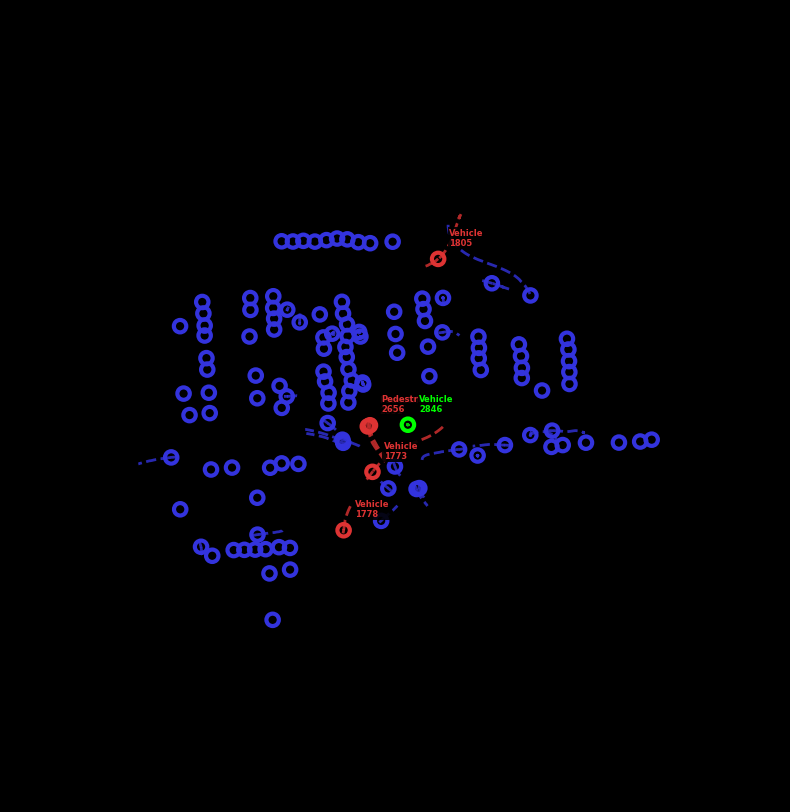

In this scenario there are 31 out of 128 possible agents. 
We have measurements about 10 past steps, 1 current step and 80 future steps.
Agent #1 with ID 1435 is  Vehicle.
Vehicle
Vehicle
Vehicle


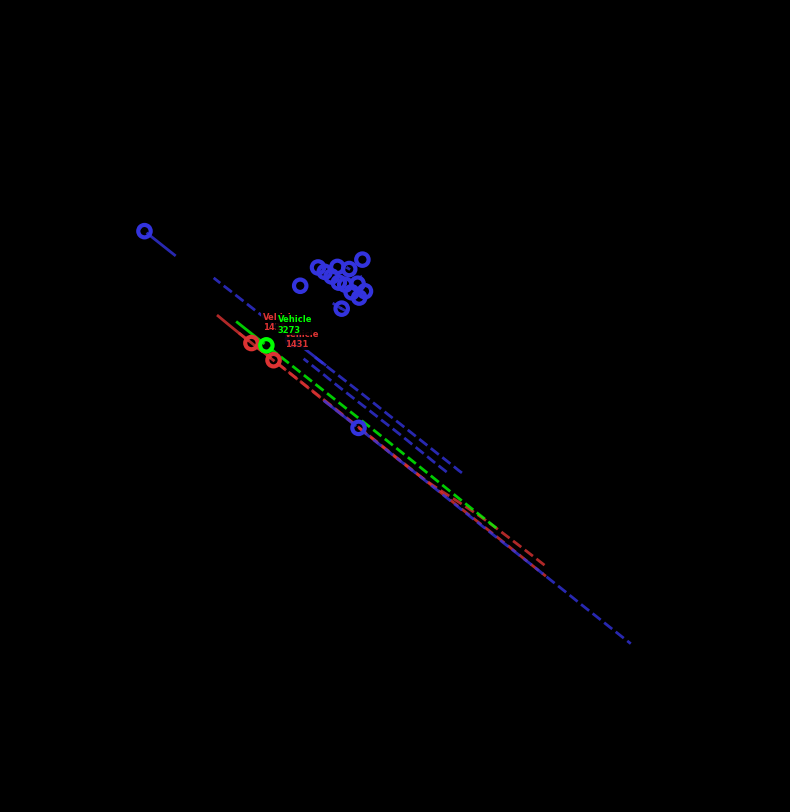

In this scenario there are 31 out of 128 possible agents. 
We have measurements about 10 past steps, 1 current step and 80 future steps.
Agent #1 with ID 1580 is SDC Vehicle.
Vehicle
Vehicle


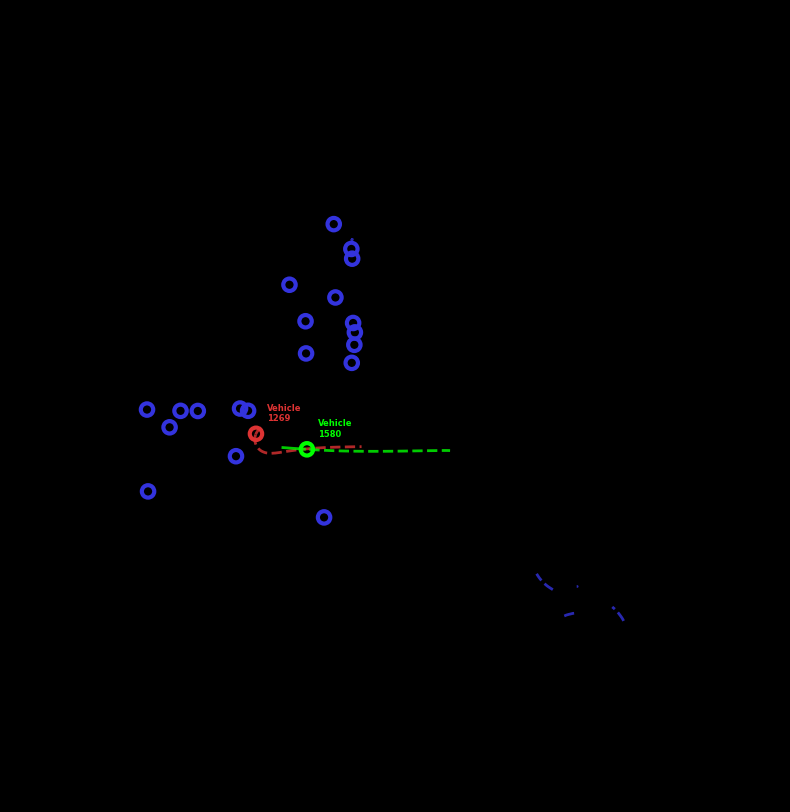

In this scenario there are 12 out of 128 possible agents. 
We have measurements about 10 past steps, 1 current step and 80 future steps.
Agent #1 with ID 370 is  Vehicle.
Vehicle
Vehicle
Vehicle


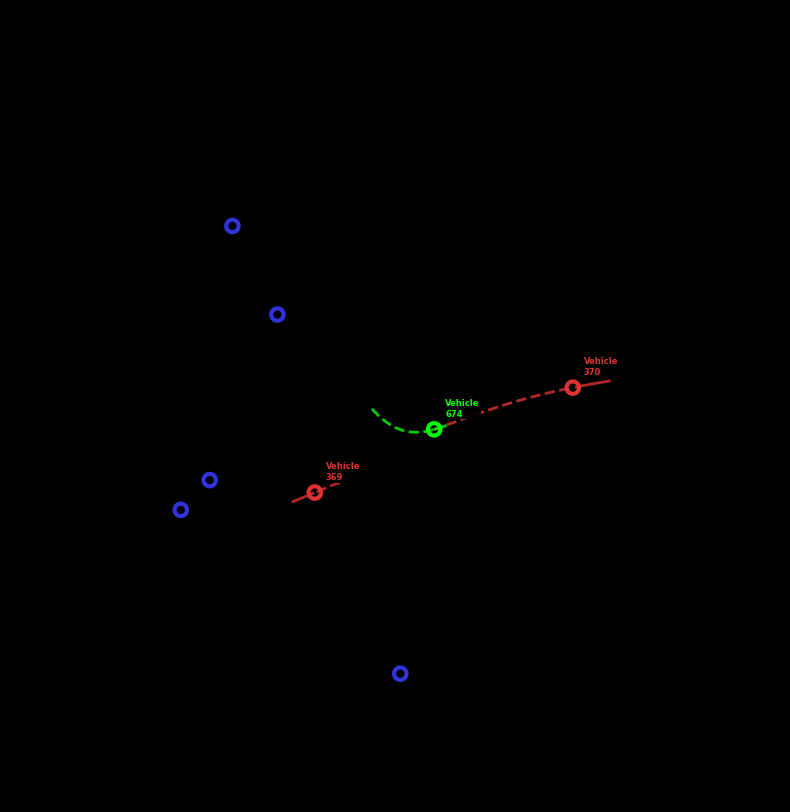

In this scenario there are 88 out of 128 possible agents. 
We have measurements about 10 past steps, 1 current step and 80 future steps.
Agent #1 with ID 1491 is  Pedestrian.
Vehicle
Pedestrian
Vehicle


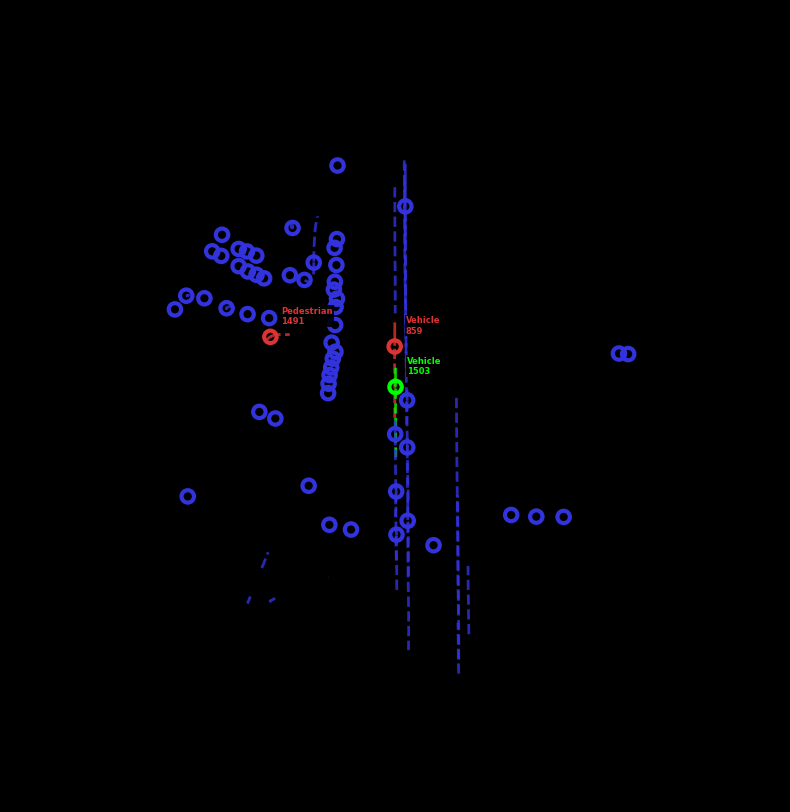

In [7]:
for i in range(5):
    visualize_from_example(training_dataset[0][i])